In [1]:
import pickle
import glob
import os
import scipy.sparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helper_functions import *
from annoy import AnnoyIndex
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

# Compute tuples or artists and users

In [2]:
matrix_plays = scipy.sparse.load_npz('../data/matrix_plays.npz')

In [3]:
# Load precomputed data
user2id = load_pickle('../data/user2id.pickle')
id2user = load_pickle('../data/id2user.pickle')
artist2id = load_pickle('../data/artist2id.pickle')
id2artist = load_pickle('../data/id2artist.pickle')

## Compute random user jumper and user jumper tuples for the artist embedding

In [4]:
NB_SAMPLE = 2000

In [5]:
idx_artists = list(load_pickle('../data/artist_embeddings/word2vec/word2vec_100.pickle')['index'].apply(lambda x: artist2id[x]))
idx_users = list(load_pickle('../data/user_embeddings/word2vec/word2vec_100.pickle')['index'].apply(lambda x: user2id[x]))


In [6]:
S1 = matrix_plays

In [7]:
'''
Random user jumper: Selects pair of random artists.
'''
if not os.path.exists("../data/artist_embeddings/random_user_jumper_tuples.pickle"):
    selected_artists = np.random.choice(idx_artists, size = (NB_SAMPLE, 2), replace=False)
    artists_tuples = []
    for tup in selected_artists:
        artists_tuples.append((tup[0], tup[1]))
    save_to_pickle(artists_tuples, 'random_user_jumper_tuples', '../data/artist_embeddings/')

In [8]:
'''
User jumper: Select NB_SAMPLE users from the set of users and for each user selected, we select 2 artists
'''
if not os.path.exists("../data/artist_embeddings/user_jumper_tuples.pickle"):
    selected_users = np.random.choice(range(S1.shape[0]), size = (S1.shape[0]), replace=False)

    matrix_plays_filter = S1[:, selected_users]

    # Create and store artists tuples
    artists_tuples = []
    for i in range(matrix_plays_filter.shape[1]):
        idx = list(set(matrix_plays_filter[:, i].nonzero()[0]).intersection(set(idx_artists)))
        selected_artist = np.random.choice(idx, 2, replace=False)
        artists_tuples.append((selected_artist[0], selected_artist[1]))

        if len(artists_tuples) >= NB_SAMPLE:
            break

    save_to_pickle(artists_tuples, 'user_jumper_tuples', '../data/artist_embeddings/')

## Compute random artist jumper and artist jumper tuples for the user embedding

In [9]:
S2 = matrix_plays.T

In [10]:
'''
Random artist jumper: Selects pair of random users.
'''
if not os.path.exists("../data/user_embeddings/random_artist_jumper_tuples.pickle"):
    selected_users = np.random.choice(idx_users, size = (NB_SAMPLE, 2), replace=False)
    users_tuples = []
    for tup in selected_users:
        users_tuples.append((tup[0], tup[1]))
    save_to_pickle(users_tuples, 'random_artist_jumper_tuples', '../data/user_embeddings/')

In [11]:
'''
Artist jumper: Select NB_SAMPLE artists from the set of users and for each artist selected, we select 2 users.
'''
if not os.path.exists("../data/user_embeddings/artist_jumper_tuples.pickle"):
    selected_artists = np.random.choice(idx_artists, size = (len(idx_artists)), replace=False)

    S2_filter = S2[:, selected_artists]

    # Create and store artists tuples
    users_tuples = []
    for i in range(S2_filter.shape[1]):
        idx = list(set(S2_filter[:, i].nonzero()[0]).intersection(set(idx_users)))
        selected_users = np.random.choice(idx, 2, replace=False)
        users_tuples.append((selected_users[0], selected_users[1]))

        if len(users_tuples) >= NB_SAMPLE:
            break

    save_to_pickle(users_tuples, 'artist_jumper_tuples', '../data/user_embeddings/')

# Compute embedding metrics

In the following methods, `item` refers either to `user` or `artist`.

In [182]:
'''
Create a Pandas DataFrame from the embedding
PARAMETERS:
    - model_path: Path where the embedding is stoed
    - embedding_type: user or artist embedding
    - dim_type: the dimentionality reduction algorithm used
RETURN:
    - df: Pandas DataFrame
'''
def get_dataframe_in_embedding_space(model_path, embedding_type='users', dim_type='pca'):
    if dim_type == 'pca':
        graph_matrix = load_pickle(model_path)
        df = pd.DataFrame(graph_matrix)
        df = df.rename(lambda x: 'd_'+ str(x), axis='columns')
        return df
    else:
        df = load_pickle(model_path)
        if embedding_type == 'artists':
            df['index'] = df['index'].apply(lambda x: artist2id[x])
        elif embedding_type == 'users':
            df['index'] = df['index'].apply(lambda x: user2id[x])
        return df.set_index('index')

'''
Build the Annoy index in order to compute afterwords the nearest neighbors
PARAMETERS:
    - df: DataFrame representing the embedding space
RETURN:
    - The annoy index
'''
def get_annoy_index(df):
    nb_trees = 100 # 100 trees
    index = AnnoyIndex(df.shape[1], "euclidean")  # Length of item vector that will be indexed
    df.apply(lambda row: index.add_item(row.name, np.array(row)), axis = 1)
    index.build(nb_trees) 
    return index


'''
Get the random walk distance computed from the random_walk_items pairs. The random walk distance is the sum 
of the euclidean distance between the pairs of random_walk_items.
PARAMETERS:
    - df_embedding: DataFrame corresponding to the embedding
    - embedding_type: Our project contains 2 embeddings, a user embedding and a artist embedding
    - path: the general path where are stored the random_items_jumper_tuples
RETURN:
    - random_walk_distance: The distance of the random walk
'''
def get_random_walk(df_embedding, embedding_type, path):
    if embedding_type == 'users':
        random_walk_items = load_pickle(path + 'random_artist_jumper_tuples.pickle')
    elif embedding_type == 'artists':
        random_walk_items = load_pickle(path + 'random_user_jumper_tuples.pickle')
    
    random_walk_distance = 0
    for val in random_walk_items:
        random_walk_distance += distance.euclidean(df_embedding.loc[val[0]], df_embedding.loc[val[1]])
    return random_walk_distance



'''
Get the position of ref_item relative to second_item in terms of its nearest neighbors ranking.
PARAMETER:
    - ref_item: The reference item on which we compute the k nearest neighbors
    - second_item: The item on which we compute the ranking relatively to ref_item
    - index: Annoy index to compute the neirest neighbors
    - df_embedding: DataFrame representing the items in the embedding space
RETURN:
    - The position of second_item relatively to ref_item in terms of it's ranking
'''
def get_ranking_position_between_items(ref_item, second_item, index, df_embedding):
    nearest_neighbors_index = index.get_nns_by_item(ref_item, len(df_embedding))
    dist_k_th_nearest = distance.euclidean(df_embedding.loc[ref_item], 
                                           df_embedding.loc[nearest_neighbors_index[len(nearest_neighbors_index)-1]])
    for i in range(0, len(nearest_neighbors_index)):
        if nearest_neighbors_index[i] == second_item:
            return i
        
        
        
        
'''
Compute the Jumper ratio as well as the position ratio.
PARAMETER:
    - files: List of path where are stored the embedding
    - embedding_type: Our project contains 2 embeddings, a user embedding and a artist embedding
    - path: path where are stored the item_jumper_tuples
    - dim_type: the dimentionality reduction algorithm used
RETURN: 
    - user_jumper_tab: List of Jumper ratio corresponding the embedding contained in files
    - ranking_position_tab: List of Position ratio corresponding the embedding contained in files
'''
def get_user_walk_and_position_ratio(files, embedding_type, path, dim_type):
    
    if embedding_type == 'users':
        items_tuple = load_pickle(path + 'artist_jumper_tuples.pickle')
    elif embedding_type == 'artists':
        items_tuple = load_pickle(path + 'user_jumper_tuples.pickle')
    
    len_random_set = len(items_tuple)
    
    user_jumper_tab = []
    ranking_position_tab = []

    for file in files:     
        print('file ', file)                  
        df_embedding = get_dataframe_in_embedding_space(file, embedding_type, dim_type)
        n_comp = df_embedding.shape[1]
        print('n_comp ', n_comp)
        random_walk_distance = get_random_walk(df_embedding, embedding_type, path)
        index = get_annoy_index(df_embedding)
        users_walk = 0
        ranking_position = 0
        
        temp_user_jumper_tab = []
        temp_ranking_position_tab = []
        
        for ind, item in enumerate(items_tuple):
            ref_item = item[0]
            second_item = item[1]
            # For every pair sum the users_walk and the ranking_position results
            temp_user_jumper_tab.append(distance.euclidean(df_embedding.loc[ref_item], df_embedding.loc[second_item])/random_walk_distance)
            temp_ranking_position_tab.append(get_ranking_position_between_items(ref_item, second_item, index, df_embedding)/(df_embedding.shape[0]*len_random_set))

        user_jumper_tab.append(temp_user_jumper_tab)
        ranking_position_tab.append(temp_ranking_position_tab)
        
    save_to_pickle(user_jumper_tab, embedding_type + '_jumper_results', path + dim_type + '/')
    save_to_pickle(ranking_position_tab, embedding_type + '_ranking_position_results', path + dim_type + '/')
        
    return user_jumper_tab, ranking_position_tab
    

In [15]:
if os.path.exists("../data/user_embeddings/pca/users_jumper_results.pickle"):
    os.remove("../data/user_embeddings/pca/users_jumper_results.pickle")
    
if os.path.exists("../data/user_embeddings/pca/users_ranking_position_results.pickle"):
    os.remove("../data/user_embeddings/pca/users_ranking_position_results.pickle")

    
user_files = glob.glob("../data/user_embeddings/pca/*.pickle")
user_jumper_tab, user_ranking_position_tab = get_user_walk_and_position_ratio(user_files, 'users', '../data/user_embeddings/', 'pca')

file  ../data/user_embeddings/pca/user_embedding_norm_transformed_pca100.pickle
n_comp  100
file  ../data/user_embeddings/pca/user_embedding_norm_transformed_pca25.pickle
n_comp  25
file  ../data/user_embeddings/pca/user_embedding_norm_transformed_pca50.pickle
n_comp  50
file  ../data/user_embeddings/pca/user_embedding_transformed_pca100.pickle
n_comp  100
file  ../data/user_embeddings/pca/user_embedding_transformed_pca25.pickle
n_comp  25
file  ../data/user_embeddings/pca/user_embedding_transformed_pca50.pickle
n_comp  50


In [16]:
if os.path.exists("../data/artist_embeddings/pca/artists_jumper_results.pickle"):
    os.remove("../data/artist_embeddings/pca/artists_jumper_results.pickle")
    
if os.path.exists("../data/artist_embeddings/pca/artists_ranking_position_results.pickle"):
    os.remove("../data/artist_embeddings/pca/artists_ranking_position_results.pickle")
    
artist_files = glob.glob("../data/artist_embeddings/pca/*.pickle")
artist_jumper_tab, artist_ranking_position_tab = get_user_walk_and_position_ratio(artist_files, 'artists', '../data/artist_embeddings/', 'pca')

file  ../data/artist_embeddings/pca/artist_embedding_norm_transformed_pca100.pickle
n_comp  100
file  ../data/artist_embeddings/pca/artist_embedding_norm_transformed_pca25.pickle
n_comp  25
file  ../data/artist_embeddings/pca/artist_embedding_norm_transformed_pca50.pickle
n_comp  50
file  ../data/artist_embeddings/pca/artist_embedding_transformed_pca100.pickle
n_comp  100
file  ../data/artist_embeddings/pca/artist_embedding_transformed_pca25.pickle
n_comp  25
file  ../data/artist_embeddings/pca/artist_embedding_transformed_pca50.pickle
n_comp  50


In [17]:
if os.path.exists("../data/artist_embeddings/word2vec/artists_jumper_results.pickle"):
    os.remove("../data/artist_embeddings/word2vec/artists_jumper_results.pickle")
    
if os.path.exists("../data/artist_embeddings/word2vec/artists_ranking_position_results.pickle"):
    os.remove("../data/artist_embeddings/word2vec/artists_ranking_position_results.pickle")

    
artist_files = glob.glob("../data/artist_embeddings/word2vec/*.pickle")
artist_jumper_tab_word2vec, artist_ranking_position_tab_word2vec = get_user_walk_and_position_ratio(artist_files, 'artists', '../data/artist_embeddings/', 'word2vec')

file  ../data/artist_embeddings/word2vec/word2vec_100.pickle
n_comp  100
file  ../data/artist_embeddings/word2vec/word2vec_25.pickle
n_comp  25
file  ../data/artist_embeddings/word2vec/word2vec_50.pickle
n_comp  50


In [20]:
if os.path.exists("../data/user_embeddings/word2vec/users_jumper_results.pickle"):
    os.remove("../data/user_embeddings/word2vec/users_jumper_results.pickle")
    
if os.path.exists("../data/user_embeddings/word2vec/users_ranking_position_results.pickle"):
    os.remove("../data/user_embeddings/word2vec/users_ranking_position_results.pickle")

    
user_files = glob.glob("../data/user_embeddings/word2vec/*.pickle")
user_jumper_tab_word2vec, user_ranking_position_tab_word2vec = get_user_walk_and_position_ratio(user_files, 'users', '../data/user_embeddings/', 'word2vec')

file  ../data/user_embeddings/word2vec/word2vec_100.pickle
n_comp  100
file  ../data/user_embeddings/word2vec/word2vec_25.pickle
n_comp  25
file  ../data/user_embeddings/word2vec/word2vec_50.pickle
n_comp  50


## User embedding

From the results below, we can observe that pca with tf-idf weights and 25 dimensions have the lowest results.

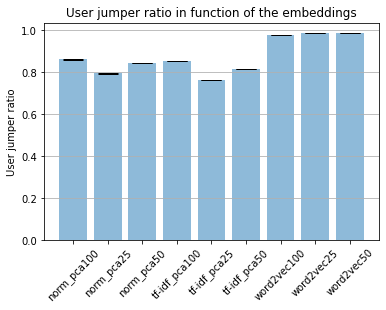

In [46]:
fig, ax = plt.subplots()
ax.bar(['norm_pca100', 'norm_pca25', 'norm_pca50', 'tf-idf_pca100', 'tf-idf_pca25', 'tf-idf_pca50', 'word2vec100', 'word2vec25', 'word2vec50'],
       np.append(np.array(user_jumper_tab).sum(axis = 1), np.array(user_jumper_tab_word2vec).sum(axis = 1)),
       yerr=np.append(np.array(user_jumper_tab).std(axis = 1), np.array(user_jumper_tab_word2vec).std(axis = 1)),
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('User jumper ratio')
plt.xticks(rotation=45)
ax.set_title('User jumper ratio in function of the embeddings')
ax.yaxis.grid(True)
plt.show()

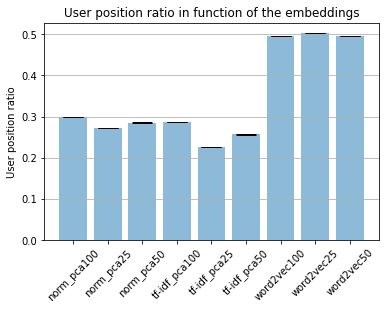

In [47]:
fig, ax = plt.subplots()
ax.bar(['norm_pca100', 'norm_pca25', 'norm_pca50', 'tf-idf_pca100', 'tf-idf_pca25', 'tf-idf_pca50', 'word2vec100', 'word2vec25', 'word2vec50'],
       np.append(np.array(user_ranking_position_tab).sum(axis = 1), np.array(user_ranking_position_tab_word2vec).sum(axis = 1)),
       yerr=np.append(np.array(user_ranking_position_tab).std(axis = 1), np.array(user_ranking_position_tab_word2vec).std(axis = 1)),
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('User position ratio')
plt.xticks(rotation=45)
ax.set_title('User position ratio in function of the embeddings')
ax.yaxis.grid(True)
plt.show()

### Artists embedding

The best position ratio result has been obtained by the normalized pca with 25 dimensions.

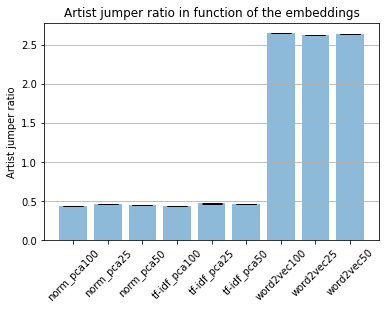

In [48]:
fig, ax = plt.subplots()
ax.bar(['norm_pca100', 'norm_pca25', 'norm_pca50', 'tf-idf_pca100', 'tf-idf_pca25', 'tf-idf_pca50', 'word2vec100', 'word2vec25', 'word2vec50'],
       np.append(np.array(artist_jumper_tab).sum(axis = 1), np.array(artist_jumper_tab_word2vec).sum(axis = 1)),
       yerr=np.append(np.array(artist_jumper_tab).std(axis = 1), np.array(artist_jumper_tab_word2vec).std(axis = 1)),
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Artist jumper ratio')
plt.xticks(rotation=45)
ax.set_title('Artist jumper ratio in function of the embeddings')
ax.yaxis.grid(True)
plt.show()

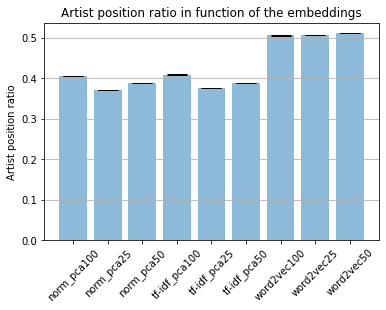

In [49]:
fig, ax = plt.subplots()
ax.bar(['norm_pca100', 'norm_pca25', 'norm_pca50', 'tf-idf_pca100', 'tf-idf_pca25', 'tf-idf_pca50', 'word2vec100', 'word2vec25', 'word2vec50'],
       np.append(np.array(artist_ranking_position_tab).sum(axis = 1), np.array(artist_ranking_position_tab_word2vec).sum(axis = 1)),
       yerr=np.append(np.array(artist_ranking_position_tab).std(axis = 1), np.array(artist_ranking_position_tab_word2vec).std(axis = 1)),
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Artist position ratio')
plt.xticks(rotation=45)
ax.set_title('Artist position ratio in function of the embeddings')
ax.yaxis.grid(True)
plt.show()

## Appendix: 
___________________________

## Axis projection method

In [188]:
'''
For the given ref_item, compute pairs of item between ref_item's k neirest neighbor and ref_item.
PARAMETERS:
    - items_pairs: List of tuple representing the pair of items already computed,
    - ref_item: the item on which we compute the neirest neighbor search,
    - index: the annoy index to do the nearest neighbor search,
    - k: the number of neighbors to be computed
'''
def create_pairs(item_pairs, ref_item, index, k):
    nearest_neighbors = index.get_nns_by_item(ref_item, k)
    for neighbor_item in nearest_neighbors:
        item_pairs.append((ref_item, neighbor_item))
        
        
        
'''
Generate the set of all pairs of tems with their k neirest neighbors
PARAMETERS:
    - df_embedding: DataFrame representing the tem embedding
    - k: the parameter of the nearest neighbor search
    - n_comp: the number of components of the embedding (number of columns of the embedding)
    - seed: the seed pair
RETURN:
    - DataFrame representing all the tems - nearest neighbors pairs 
'''
def items_with_neighbors_pairs(df_embedding, k, n_comp, seed):
    items_pairs = []
    index = get_annoy_index(df_embedding)
    
    for item in df_embedding.index:
        if not item == seed[0] and not item == seed[1]:
            create_pairs(items_pairs, item, index, k)
    return pd.DataFrame(items_pairs)


'''
Create the pairs of item - nearest neighbors for each item.
Then compute and sort the pairs according to their cosine similarity scores.
PARAMETERS:
    - path: the path where the embedding is stored,
    - k: the number of neirest neighbor search,
    - seed: the selected seed pair,
    - nb_selected_pairs: number of selected pairs to create the axis,
    - selected_items: the subset of items if we want to work on a subset of the items,
    - item_crawler: DataFrame having the name - item mapping,
    - dict_ind_itemchannel: mapping from items indices to itemchannels id
RETURN:
    - Call cultural_concept_vector function in order to compute the final axis vector.
'''

def compute_axis_vector_based_on_seed(path, k, seed, nb_selected_pairs, item_crawler, dict_ind_itemchannel):
    
    # DataFrame representing the embedding
    df_embedding = get_dataframe_in_embedding_space(path)
    
    n_comp = df_embedding.shape[1]

    items_pairs = items_with_neighbors_pairs(df_embedding, k, n_comp, seed)
    
    # Vectors representing the difference between every pairs of items in itemchannels_pairs
    vector_diff_items_pairs = np.array(items_pairs.apply(lambda row: df_embedding.loc[row[0]] - df_embedding.loc[row[1]], axis = 1))
    
    # Vector difference between the seed pair
    vector_diff_seed = np.array(df_embedding.loc[seed[0]] - df_embedding.loc[seed[1]])
    
    # compute cosine similarity score
    similarity_score = cosine_similarity(vector_diff_items_pairs, vector_diff_seed.reshape(1, -1))
    items_pairs['similarity'] = similarity_score
    # Sort the similrity scores
    items_pairs = items_pairs.sort_values(by = ['similarity'], ascending = False)
    
    return cultural_concept_vector(df_embedding, items_pairs, vector_diff_seed, nb_selected_pairs, seed, item_crawler, dict_ind_itemchannel)


'''
Creates the axis vector representing the desired cultural concept based on the seed pair. To create the axis, the vector difference of all nb_pairs_selected are averaged together to obtain a single vector 
for the axis that robustly represents the desired cultural concept.
PARAMETERS:
    - df_embedding: DataFrame representing the item embedding
    - sorted_similarity_score: dataframe of itemchannel pairs ordered by their cosine similarity score
    - vector_diff_seed: vector difference between the seed pair
    - nb_selected_pairs: number of selected pairs to create the axis
    - seed: the seed pair
    - item_crawler: Pandas DataFrame having the name - item mapping
    - dict_ind_itemchannel: mapping from items indices to items id
RETURN:
    - Axis vector (of dimension = # columns of the embedding) that represents the desired cultural concept
'''

def cultural_concept_vector(df_embedding, sorted_similarity_score, vector_diff_seed, nb_selected_pairs, seed, item_crawler, dict_ind_item):
    
    df_output = pd.DataFrame() # Dataframe to print the selected pairs
    
    selected_items_pairs = [seed] # All the selected items pairs
    
    # Select and print the items that we take to create the axis
    count_selected_pairs = 0 # Counter to keep track of how many pairs we have selected so far
    idx = 0 # Indice counter
    
    items_already_taken = [seed[0], seed[1]]
    df_output = df_output.append(item_crawler[item_crawler['artist_id'] == dict_ind_item[seed[0]]])
    df_output = df_output.append(item_crawler[item_crawler['artist_id'] == dict_ind_item[seed[1]]])
        
    while count_selected_pairs < nb_selected_pairs-1:
        pair = sorted_similarity_score.loc[idx]
        
        # We don't want items to be selected multiple times
        if not(pair[0] in items_already_taken or pair[1] in items_already_taken) and pair[0] != pair[1]:
            df_output = df_output.append(item_crawler[item_crawler['artist_id'] == dict_ind_item[pair[0]]])
            df_output = df_output.append(item_crawler[item_crawler['artist_id'] == dict_ind_item[pair[1]]])
            
            selected_items_pairs.append((pair[0], pair[1]))
            
            items_already_taken.append(pair[0])
            items_already_taken.append(pair[1])
            count_selected_pairs += 1
        idx += 1
    
    cultural_concept_vectors = [vector_diff_seed] # Vectors of the difference of the selected pairs
    # Create the axis vector by taking the mean of the vector difference of the selected pairs
    for item_pair in selected_items_pairs:
        cultural_concept_vectors.append(np.array(df_embedding.loc[item_pair[0]]) - np.array(df_embedding.loc[item_pair[1]]))
    cultural_concept_vectors = np.array(cultural_concept_vectors)
    
    return cultural_concept_vectors.mean(axis = 0), df_output

In [136]:
# Number of neirest neighbors taken
k = 10

# Selected number of pairs to create the axis
nb_selected_pairs = 5

### Finding cultural axis

In [56]:
col_names_consumption = ['user-mboxsha1', 'musicbrainz-artist-id', 'artist-name', 'plays']

df_plays = pd.read_csv('../data/usersha1-artmbid-artname-plays.tsv', sep='\t', names=col_names_consumption)
df_plays = df_plays.rename({'user-mboxsha1':'user_id', 'musicbrainz-artist-id':'artist_id', 'artist-name': 'artist_name'}, axis=1)
df_plays = df_plays.groupby('artist_id').head(1)
df_plays = df_plays[(df_plays['artist_id'].isin(list(artist2id.keys())))]
df_plays.head()

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [103]:
PATH = '../data/artist_embeddings/pca/artist_embedding_transformed_pca25.pickle'

### Gender axis

In [176]:
df_plays[df_plays['artist_name'].str.startswith('rihanna', na=False)]

,user_id,artist_id,artist_name,plays,artist_idx
371,0000ef373bbd0d89ce796abae961f2705e8c1faf,73e5e69d-3554-40d8-8516-00cb38737a1c,rihanna,36,20326


In [120]:
df_plays[df_plays['artist_name'].str.startswith('drake', na=False)]

,user_id,artist_id,artist_name,plays,artist_idx
5255,0012380744768a379461293f1bda83c165b7db36,9fff2f8a-21e6-47de-a2b8-7f449929d43f,drake,288,28200
16848,003cb4ad6399ea5268b39fd15df47c17e3f4d52a,094f10e7-27d5-400d-a145-331013e67229,drake bell,76,1662


In [219]:
gender_seed_name = ('rihanna', 'drake')

In [189]:
gender_seed = (artist2id['73e5e69d-3554-40d8-8516-00cb38737a1c'], artist2id['9fff2f8a-21e6-47de-a2b8-7f449929d43f'])

gender_axis, df_gender_axis = compute_axis_vector_based_on_seed(PATH, k, gender_seed, nb_selected_pairs, df_plays, id2artist)


### Visualisation of the created axis

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

'''
Compute the projection score for each item
PARAMETER:
    - axis_vector: Vector representing the axis.
    - item_vector: Vector representing the item
RETURN:
    - The projection score
'''
def compute_projection(axis_vector, item_vector):
    return np.dot(axis_vector, item_vector)

'''
Enable to plot and save the distribution of the scores stored in df_gender_projection
PARAMETER:
    - df_gender_projection: DataFrame (name of the item, score)
    - seed_name: pair corresponding to the name of the seed
    - color: String correponding to the Colormaps color
'''
def visualization(df_gender_projection, seed_name, color, nb_for_color, title, save_path = None):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting a histogram of the scores with 30 equal-witdh bins
    n, bins, patches = ax.hist(df_gender_projection['projection'], bins=100, color='green')
    ax.set_ylabel('# item')
    ax.set_xlabel('Projection score')

    # This is  the colormap I'd like to use.
    cm = plt.cm.get_cmap(color)

    for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(i/nb_for_color)) 


    # Annotate the seed pair
    x_position = int(list(df_gender_projection[df_gender_projection['name'] == seed_name[0]]['projection'])[0])
    y_position = ax.get_ylim()[1]/10
    ax.annotate(seed_name[0], (x_position, 0), (x_position, y_position), arrowprops = dict(arrowstyle="->"), horizontalalignment='center')


    x_position = int(list(df_gender_projection[df_gender_projection['name'] == seed_name[1]]['projection'])[0])
    y_position = -ax.get_ylim()[1]/10
    ax.annotate(seed_name[1], (x_position, 0), (x_position, y_position), arrowprops = dict(arrowstyle="->"), horizontalalignment='center')

    ax.legend()
    ax.set_title(title)
    if save_path != None:
        plt.savefig(save_path)
    plt.show()
    
    
def create_projection(EMBEDDING, axis_vector, dict_idx_name):
    df_projection = pd.DataFrame({'name': EMBEDDING.apply(lambda row: dict_idx_name[row.name], axis = 1)})
    df_projection['projection'] = EMBEDDING.apply(lambda item_vector: compute_projection(axis_vector, item_vector), axis = 1)
    return df_projection



def create_plot(df_left, df_right, selected_pairs, title, size, cm, resize = 1, save_path = None):
    fig, ax = plt.subplots(figsize = size)
    ax.axis('off')
    X = np.arange(selected_pairs)
    for ind in X:
        ax.annotate(df_left['name'].loc[ind], (0, 0), (df_left['projection'].loc[ind] - 1, ind-0.05), horizontalalignment='right')
        ax.annotate(df_right['name'].loc[ind], (0, 0), (df_right['projection'].loc[ind] + 1, ind-0.05), horizontalalignment='left')

        ax.annotate(round(df_left['projection'].loc[ind], 2), (0, 0), (-0.1, ind-0.05), horizontalalignment='right', color = 'w')
        ax.annotate(round(df_right['projection'].loc[ind], 2), (0, 0), (0.1, ind-0.05), horizontalalignment='left', color = 'w')

    ax.barh(X, np.array(df_left['projection'])*resize, color = cm(10))
    ax.barh(X, np.array(df_right['projection'])*resize, color = cm(300))
    ax.set_title(title)
    if save_path != None:
        plt.savefig(save_path)
    plt.show()

In [105]:
EMBEDDING = get_dataframe_in_embedding_space(PATH)

In [71]:
'''
Generate the mapping between the name of the item and the indice of the item
PARAMETERS:
    - df_plays: Pandas DataFrame having the name - item mapping
    - dict_ind_item: dictionary mapping the items indices to the items id
RETURN:
    - dict_idx_name: dictionary mapping the items indices to the items names
    - dict_name_idx: dictionary mapping the items names to the items indices
'''
def item_to_name(df_plays, dict_itemchannel_ind):
    dict_item_name = {}
    df_plays['artist_idx'] = df_plays['artist_id'].apply(lambda x: dict_item_ind[x])
                                                   
    dict_idx_name = df_plays[['artist_idx', 'artist_name']].set_index('artist_idx').to_dict()['artist_name']
    dict_name_idx = df_plays[['artist_name', 'artist_idx']].set_index('artist_name').to_dict()['artist_idx']
    
    return dict_idx_name, dict_name_idx

In [106]:
id2artist_name, artist_name2id = item_to_name(df_plays, artist2id)

#### Projection of the gender axis

In [220]:
df_gender_projection = create_projection(EMBEDDING, gender_axis, id2artist_name)

In [221]:
df_gender_projection.sort_values(by='projection').head()

,name,projection
40607,voetsek,-0.000003
17920,4ft fingers,-0.000003
39302,silmarils,-0.000003
26241,bombs over providence,-0.000003
41595,kojak,-0.000003


In [222]:
df_gender_projection.sort_values(by='projection').tail()

,name,projection
19056,grupo revelação,0.000046
20989,daniel indart,0.000047
3775,20 fingers,0.000056
30777,stuart chatwood & inon zur,0.000064
25349,harmonia do samba,0.000072


No handles with labels found to put in legend.


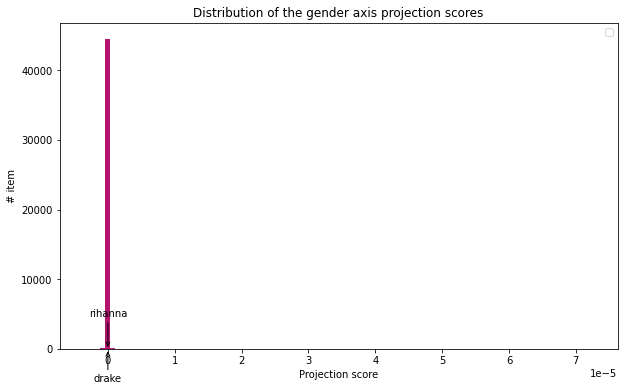

In [235]:
visualization(df_gender_projection, gender_seed_name, 'PiYG', 56, 'Distribution of the gender axis projection scores', save_path = '../data/artist_embeddings/gender_projection_pca25_tdidf.pdf')


In [224]:
wom_artists = ['jennifer lopez', 'beyoncé', 'selena gomez', 'shakira']
men_artists = ['florida', 'dj khaled', 'big sean', 'kid cudi']

In [225]:
df_gender_projection[df_gender_projection['name'].isin(wom_artists)]

,name,projection
4222,beyoncé,2.037449e-07
33653,shakira,1.914074e-07
40247,selena gomez,3.994675e-07
42287,jennifer lopez,2.086489e-07


In [216]:
df_gender_projection[df_gender_projection['name'].isin(men_artists)]

,name,projection
1432,dj khaled,-1.966886e-08
26085,big sean,-1.215343e-08
31830,florida,-2.002780e-08
39590,kid cudi,-2.086029e-08
